# Assignment 04 - Garbage Bin Classification problem 


For this project, a garbage classification model is designed and implemented using a convolution neural network (CNN).

- **Blue bin** (recyclable): 2,398 images
- **Green bin** (compostable):      826 images
- **Black bin** (landfill):         844 images 

The development set can be downloaded here:

- [GDrive](https://drive.google.com/file/d/1-q56xKd4yEsFo5xwz5Rd1Zn_lyCXLaMU/view?usp=sharing)

The data has already been pre-processed. Images were resized to 512 x 400 pixels and converted to PNG. Be mindful that a considerable number of samples in the development set may have been incorrectly labelled. You are free to fix some of the labels if you think this will help to develop your model. [See what goes where](https://www.calgary.ca/uep/wrs/what-goes-where/default.html) to get information about the labels.



## 1. Model development;

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.1 Importing Libraries

In [ ]:
#Import the necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import glob
from skimage import transform
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Activation,Input
import tensorflow_datasets as tfds

### 1.2 Loading the dataset

In [ ]:
fpath = r"/content/drive/MyDrive/Assignment 4/Development"# Loading the dataset content
random_seed = 111


categories = os.listdir(fpath)
for directory in categories:
    if directory == ".DS_Store":
        categories.remove(directory) # remove .DS_Store from list
    else:
        pass
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['Black', 'Blue', 'Green'] 

No. of categories =  3


In [ ]:
# categories = ["Black", "Blue", "Green"]
images = np.asarray(glob.glob(fpath + "/*/*.png"))
labels = np.asarray([f.split("/")[-2] for f in images])
print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(len(images))
print(images[:4])
print(labels[:5])


Images shape =  (3768,) 
Labels shape =  (3768,)
3768
['/content/drive/MyDrive/Assignment 4/Development/Black/black_423.png'
 '/content/drive/MyDrive/Assignment 4/Development/Black/black_74.png'
 '/content/drive/MyDrive/Assignment 4/Development/Black/black_234.png'
 '/content/drive/MyDrive/Assignment 4/Development/Black/black_532.png']
['Black' 'Black' 'Black' 'Black' 'Black']


In [ ]:
# Representing class names as integers 
Y = np.zeros(len(labels))
for ii in range(len(categories)):
    Y[labels == categories[ii]] =  ii

In [ ]:
# Dimensions we will resize the images
img_height = 224
img_width = 224

X = np.zeros((len(images),img_height,img_width,3))
for (ii,img) in enumerate(images):
    X[ii] = transform.resize(plt.imread(img),(img_height,img_width,3))

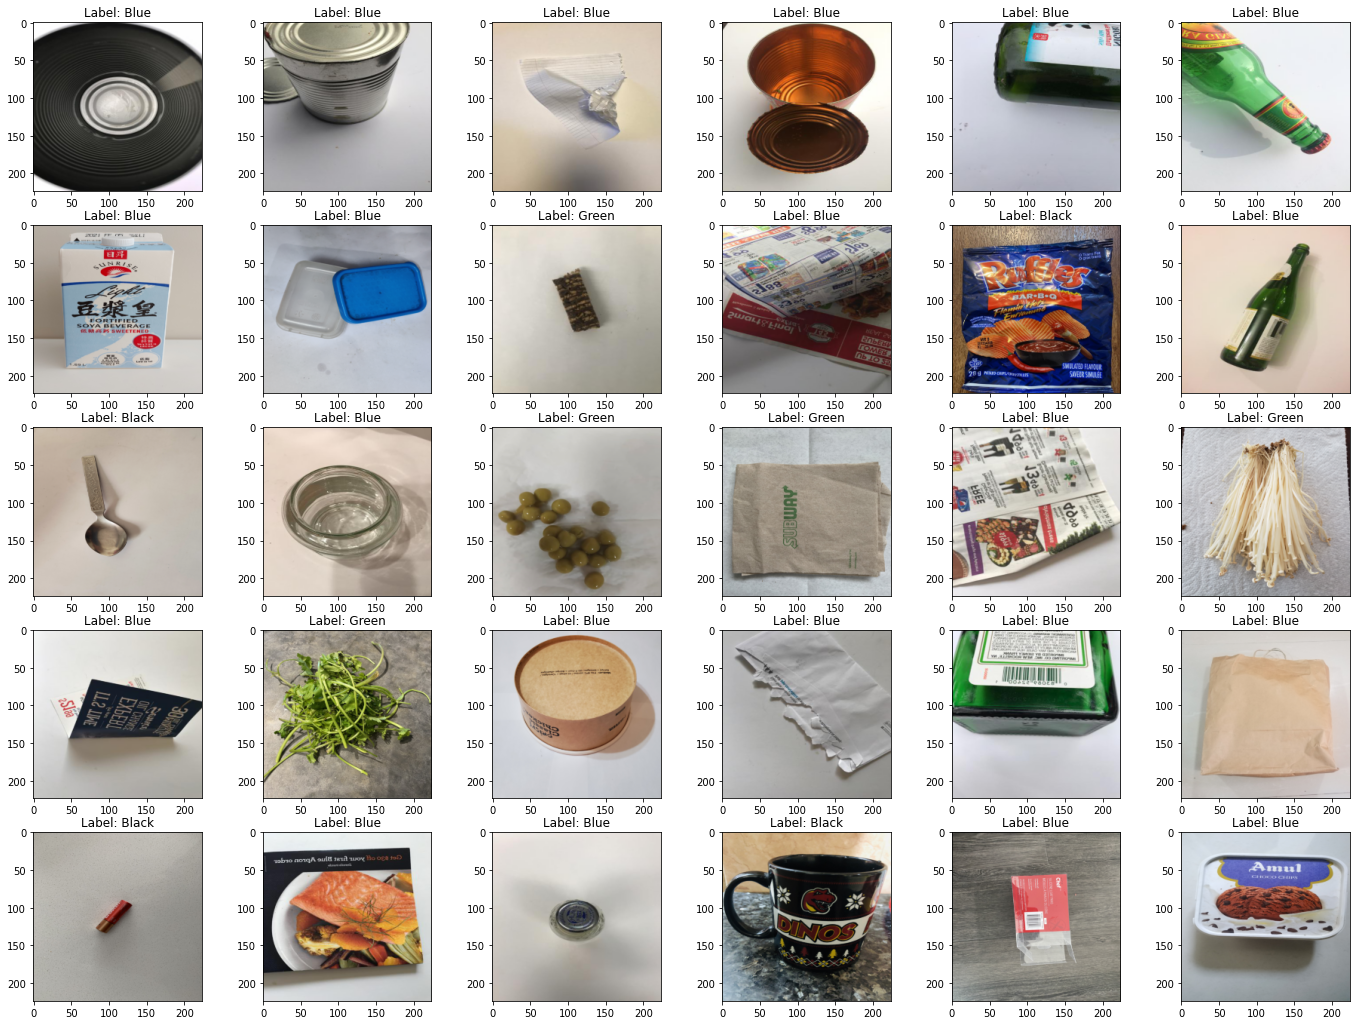

In [ ]:
# Displaying some samples from the development set
sample_indexes = np.random.choice(np.arange(X.shape[0], dtype = int),size = 30, replace = False)#Generating random noisy samples from the training set to show 
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)# Creates a 5 by 6 grid
    plt.imshow(X[jj], cmap = "gray") # Randomly chooses an image to display
    plt.title("Label: %s" %categories[int(Y[jj])])
plt.show() # Displays the 5 by 6 grid of noisy images from the training set 

In [ ]:
#The number of classes across samples looks balanced
# Let's shuffle the samples and split them
indexes = np.arange(X.shape[0], dtype = int)
np.random.shuffle(indexes)
X = X[indexes]
Y = Y[indexes]

# Train/validation/test split
nsplit = int(0.85*X.shape[0]) 
#nsplit2 = int(0.9*X.shape[0]) 
# Train and validation split

X_train = X[:nsplit]
Y_train = Y[:nsplit]
X_val = X[nsplit:]
Y_val = Y[nsplit:]


print("\nTrain set")
print("Images: ",X_train.shape)# Displays the shape of the training set
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)# Displays the shape of the validation set
print("Labels shape: ",Y_val.shape)


Train set
Images:  (3202, 224, 224, 3)
Labels shape:  (3202,)

Validation set
Images:  (566, 224, 224, 3)
Labels shape:  (566,)


In [ ]:
# The data seems to be already scale dbetween 0 and 1, so we do nothing
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())


0.0 1.0 0.5980113335103341 0.2331857373239207
0.0 1.0 0.5958993309421375 0.22958771212170487


In [ ]:
#One hot encoding
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)

print("Labels:")
print(Y_train[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[:5])
    

Labels:
[1. 2. 2. 1. 0.]

One hot encoded labels:
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [ ]:
# Data Augmentation
batch_size = 32
# gen_params is the input parameter given to the ImageDataGenerator function
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)# Creates batches of  image data with real time data augmentation with the parameters specified above
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)# the flow function is called where the input parameters are the training labels and batch size
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size)# the above function is called with validation labels

0.5642377 0.29950425
0.0 1.0


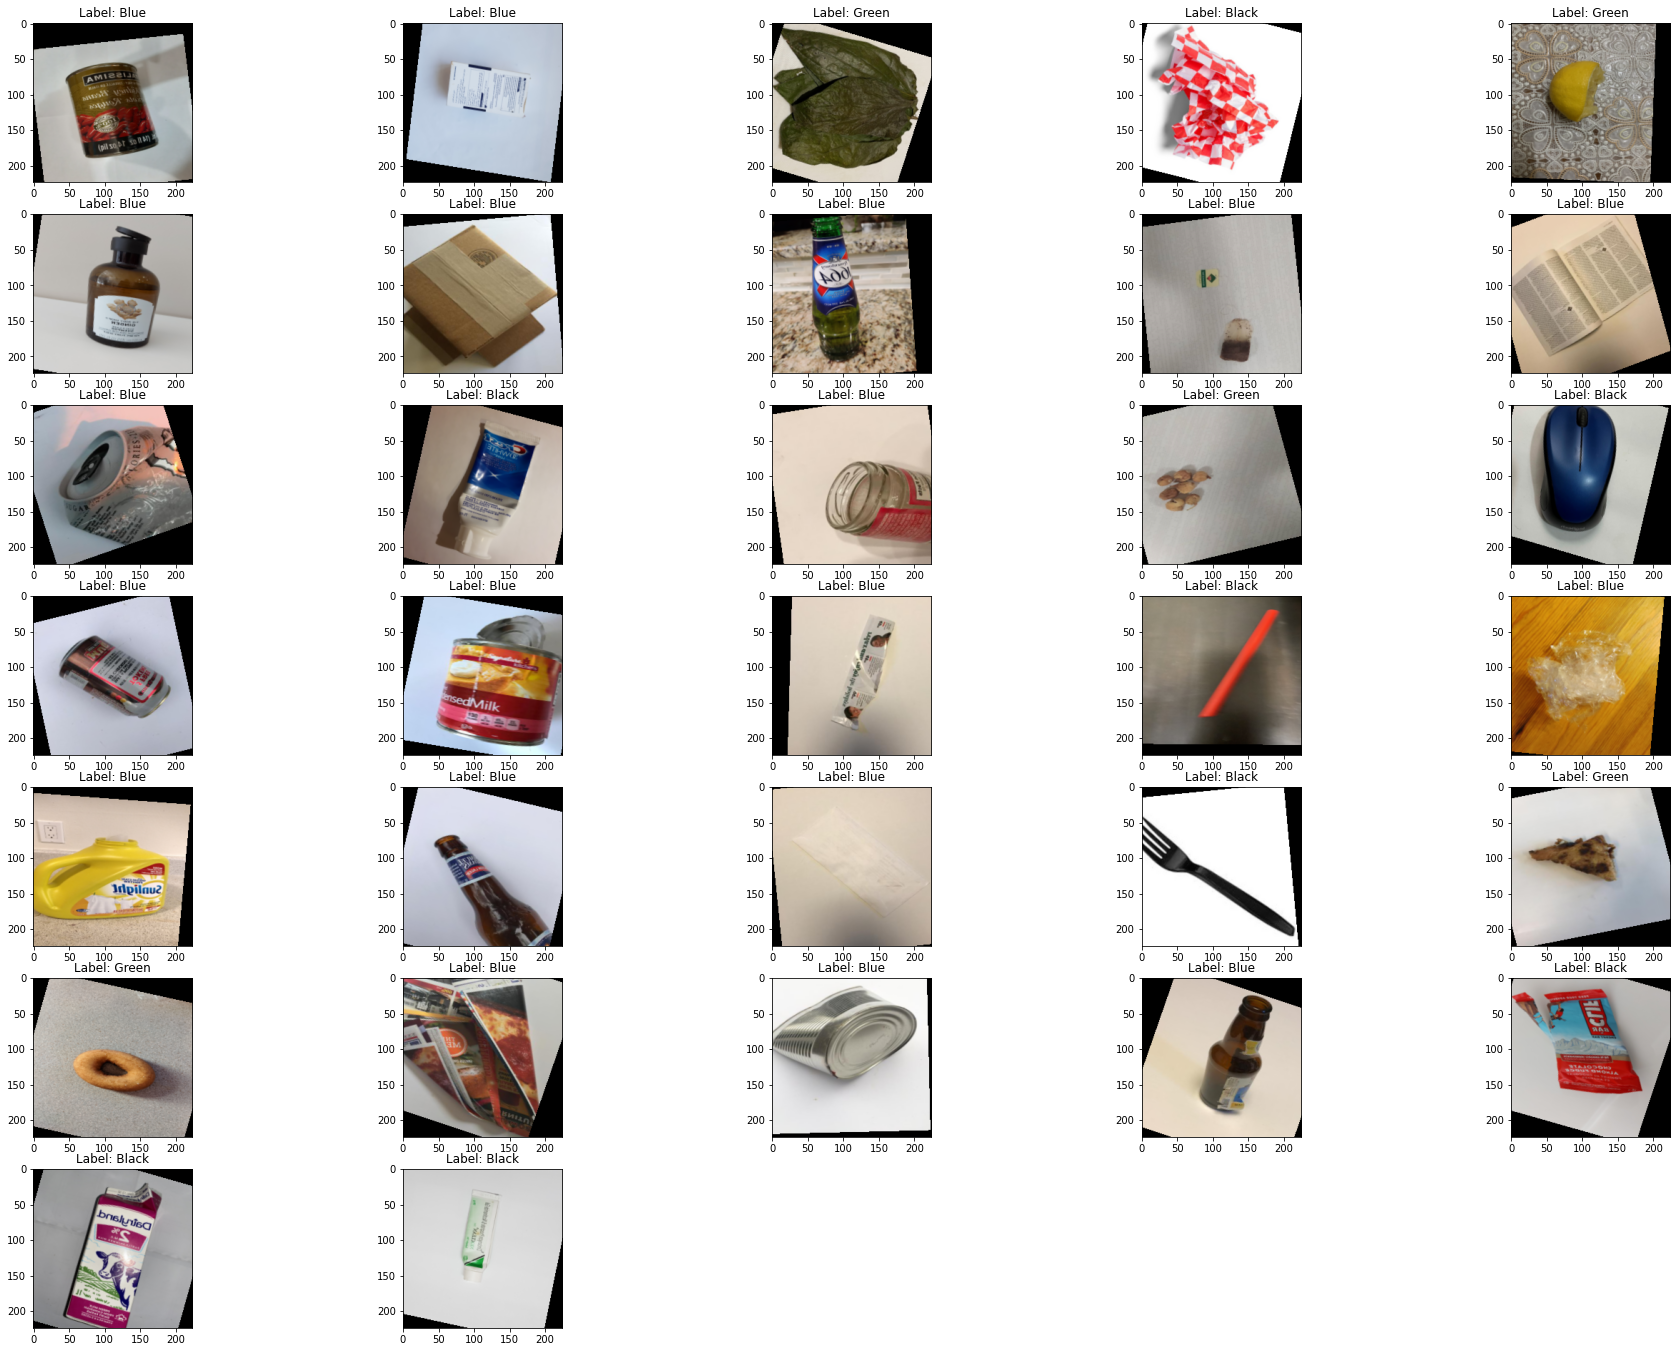

In [ ]:
# Displaying some samples from the development set
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_flow.__getitem__(0)
print(Xbatch.mean(),Xbatch.std())
print(Xbatch.min(),Xbatch.max())
# Images are plotted after data augmentation
for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    plt.title("Label: %s" %categories[int(Ybatch[ii].argmax())])
plt.show()

In [ ]:
model_name = "team_7_garbage_final.h5"
# First, We create an early-stop that monitors the validation loss and stops the training after 20 epochs if there is no improvement to prevent overfitting.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
# We then define a learning rate scheduler that reduces the learning rate by half after every 10 epochs
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
# Selecting the pre-trained model without the top layer and the layers are freezed
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)# the pretrained model is chosen without the top layer
base_model.trainable = False # the pretrained model is made non-trainable

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# adding prediction layers
input_image = tf.keras.Input(shape=(img_height, img_width, 3))
x1 = base_model(input_image, training=False)# pretrained base model
x2 = tf.keras.layers.Flatten()(x1)# the values are flatten as it is passed to the dense layer
out = tf.keras.layers.Dense(len(categories),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = input_image, outputs =out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 75267     
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# We train our model for 50 epochs with a batch size of 32
model.fit(train_flow,epochs = 50, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))



Epoch 1/50
101/101 [==============================] - 80s 419ms/step - loss: 0.8710 - accuracy: 0.6230 - val_loss: 0.6577 - val_accuracy: 0.7155
Epoch 2/50
101/101 [==============================] - 37s 364ms/step - loss: 0.6633 - accuracy: 0.7326 - val_loss: 0.6399 - val_accuracy: 0.7385
Epoch 3/50
101/101 [==============================] - 37s 365ms/step - loss: 0.6118 - accuracy: 0.7465 - val_loss: 0.5880 - val_accuracy: 0.7615
Epoch 4/50
101/101 [==============================] - 37s 367ms/step - loss: 0.5662 - accuracy: 0.7724 - val_loss: 0.5825 - val_accuracy: 0.7633
Epoch 5/50
101/101 [==============================] - 37s 366ms/step - loss: 0.5673 - accuracy: 0.7693 - val_loss: 0.5568 - val_accuracy: 0.7739
Epoch 6/50
101/101 [==============================] - 37s 368ms/step - loss: 0.5436 - accuracy: 0.7801 - val_loss: 0.5795 - val_accuracy: 0.7633
Epoch 7/50
101/101 [==============================] - 37s 366ms/step - loss: 0.5282 - accuracy: 0.7910 - val_loss: 0.5765 - val_ac

In [ ]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = True# the pretrained model is made trainable

In [ ]:
input_image = tf.keras.Input(shape=(img_height, img_width, 3))
x1 = base_model(input_image, training=True)#  pretrained model
x2 = tf.keras.layers.Flatten()(x1)# the values are flatten as it is passed to the dense layer
out = tf.keras.layers.Dense(len(categories),activation = 'softmax')(x2)
model = tf.keras.Model(input_image, out)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 75267     
Total params: 14,789,955
Trainable params: 14,789,955
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.load_weights(model_name)
# We train our model for 50 epochs with a batch size of 32
model.fit(train_flow,batch_size = 32, epochs = 50, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/50
101/101 [==============================] - 56s 505ms/step - loss: 0.4023 - accuracy: 0.8509 - val_loss: 0.5009 - val_accuracy: 0.8127
Epoch 2/50
101/101 [==============================] - 49s 488ms/step - loss: 0.3984 - accuracy: 0.8414 - val_loss: 0.5120 - val_accuracy: 0.7968
Epoch 3/50
101/101 [==============================] - 50s 489ms/step - loss: 0.3839 - accuracy: 0.8515 - val_loss: 0.4871 - val_accuracy: 0.8039
Epoch 4/50
101/101 [==============================] - 49s 488ms/step - loss: 0.3589 - accuracy: 0.8619 - val_loss: 0.5000 - val_accuracy: 0.8110
Epoch 5/50
101/101 [==============================] - 49s 486ms/step - loss: 0.3314 - accuracy: 0.8661 - val_loss: 0.5142 - val_accuracy: 0.7986
Epoch 6/50
101/101 [==============================] - 50s 490ms/step - loss: 0.3227 - accuracy: 0.8787 - val_loss: 0.5000 - val_accuracy: 0.8004
Epoch 7/50
101/101 [==============================] - 50s 489ms/step - loss: 0.3452 - accuracy: 0.8620 - val_loss: 0.5244 - val_ac

## 2. Model Testing

In [ ]:
# You are free to adapt this portion of the code, but you should 
# compute the test accuracy and show the images that 
# were classified incorrectly
test_data_dir = "/media/roberto/f5da97cf-b92d-484c-96e9-15766931cebe/Garbage-classification/Dataset-curated/Resized/Test/"

model.load_weights(model_name)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0) 
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,shuffle = False)
nb_samples = len(glob.glob(test_data_dir + "*/*"))
model.evaluate(test_generator)

In [ ]:
img = []
true_label = []
pred_label = []
for ii in range(nb_samples//batch_size):
    Xbatch,Ybatch = test_generator.__getitem__(ii)
    Ybatch = Ybatch.argmax(axis = 1)
    Ypred = model.predict(Xbatch).argmax(axis = 1)
    wrong_indexes = np.where(Ypred != Ybatch)[0]
    for ii in wrong_indexes:
        img.append(Xbatch[ii])
        true_label.append(Ybatch[ii])
        pred_label.append(Ypred[ii])

columns = 4
rows = len(img)//columns + 1    
plt.figure(figsize = (32,64))
for ii in range(len(img)):
    plt.subplot(rows,columns,ii+1)
    plt.imshow(img[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Label: %s, predicted: %ss" %(categories[true_label[ii]]\
                                            ,categories[pred_label[ii]]))
plt.show()